In [1]:
import pickle
from typing import Optional, List

import numpy as np
import matplotlib.pyplot as plt

We need some preprocessing functions to preprare the data, some functions to decide whether a neuron should be activated or not, and some metrics to get the accuracy of our model:

In [2]:
class Activation:
    """This class provides some well-known activation functions.

    Activation functions decides whether a neuron should fire or not. In other words,
    it decides a neuron should be activated or not in the network.
    """

    @staticmethod
    def sigmoid(x: np.ndarray) -> np.ndarray:
        """The sigmoid activation function.

        Read more about it here:
        https://en.wikipedia.org/wiki/Sigmoid_function
        """
        return 1 / (1 + np.exp(-x))
    
    @staticmethod
    def sigmoid_derivative(x: np.ndarray) -> np.ndarray:
        """The derivative of the sigmoid activation function."""
        return x * (1 - x)
    
    @staticmethod
    def step(x: np.ndarray) -> np.ndarray:
        """The step activation function.

        Read more about it here:
        https://en.wikipedia.org/wiki/Step_function
        """
        return 1 * (x >= 0)
    
    @staticmethod
    def step_derivative(x: np.ndarray) -> np.ndarray:
        """The derivative of the step activation function."""
        return 0  # Step function has no derivative
    
    @staticmethod
    def relu(x: np.ndarray) -> np.ndarray:
        """The rectified linear activation function.

        Read more about it here:
        https://en.wikipedia.org/wiki/Rectifier_(neural_networks)
        """
        return np.maximum(0, x)
    
    @staticmethod
    def relu_derivative(x: np.ndarray) -> np.ndarray:
        """The derivative of the rectified linear activation function."""
        return 1 * (x > 0)
    
    @staticmethod
    def leaky_relu(x: np.ndarray) -> np.ndarray:
        """The leaky rectified linear activation function.

        Read more about it here:
        https://paperswithcode.com/method/leaky-relu
        """
        return np.maximum(.01 * x, x)  # The 0.01 is our alpha that shows a small positive slope
    
    @staticmethod
    def leaky_relu_derivative(x: np.ndarray) -> np.ndarray:
        """The derivative of the leaky rectified linear activation function."""
        return 1 * (x > 0)
    
    @staticmethod
    def tanh(x: np.ndarray) -> np.ndarray:
        """The hyperbolic tangent activation function.

        Read more about it here:
        https://en.wikipedia.org/wiki/Hyperbolic_tangent
        """
        return np.tanh(x)
    
    @staticmethod
    def tanh_derivative(x: np.ndarray) -> np.ndarray:
        """The derivative of the hyperbolic tangent activation function."""
        return 1 - x ** 2

In [3]:
class Metrics:
    """Some famous accuracy metrics to evaluate the accuracy of the network.
    
    In short, they just compare actual and predicted values ​​with a formula.
    """

    @staticmethod
    def mean_absolute_error(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """The mean absolute error metric.

        Read more about it here:
        https://en.wikipedia.org/wiki/Mean_absolute_error
        """
        return np.mean(np.abs(y_true - y_pred))
    
    @staticmethod
    def mean_squared_error(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """The mean squared error metric.

        Read more about it here:
        https://en.wikipedia.org/wiki/Mean_squared_error
        """
        return np.mean((y_true - y_pred) ** 2)
    
    @staticmethod
    def root_mean_squared_error(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """The root mean squared error metric.

        Read more about it here:
        https://en.wikipedia.org/wiki/Root_mean_square_error
        """
        return np.sqrt(np.mean((y_true - y_pred) ** 2))
    
    @staticmethod
    def r2_score(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """The coefficient of determination (R^2) metric.

        Read more about it here:
        https://en.wikipedia.org/wiki/Coefficient_of_determination
        """
        return 1 - np.mean((y_true - y_pred) ** 2) / np.var(y_true)

In [4]:
class Preprocessing:
    """Preprocessing methods to prepare the data for the model.

    To prepare the data for the network, we need to normalize the data. There are so
    many ways, and here we implement some famous ones.
    """
    
    @staticmethod
    def standardize(x: np.ndarray) -> np.ndarray:
        """The standardize rescales the data using the mean and standard deviation.

        Read more about it here:    
        https://en.wikipedia.org/wiki/Standard_score
        """
        return (x - np.mean(x)) / np.std(x)
    
    @staticmethod
    def minmax_scale(x: np.ndarray) -> np.ndarray:
        """The min-max method rescales the data to a range of [0, 1].

        Read more about it here:
        https://en.wikipedia.org/wiki/Feature_scaling
        """
        return (x - np.min(x)) / (np.max(x) - np.min(x))

In [5]:
class F(Activation, Metrics, Preprocessing):
    """The `F` class contains all the activation functions, metrics and preprocessing methods.

    There is no explanation for this class, it's just a wrapper for the other classes.
    """

In [6]:
dir(F)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'leaky_relu',
 'leaky_relu_derivative',
 'mean_absolute_error',
 'mean_squared_error',
 'minmax_scale',
 'r2_score',
 'relu',
 'relu_derivative',
 'root_mean_squared_error',
 'sigmoid',
 'sigmoid_derivative',
 'standardize',
 'step',
 'step_derivative',
 'tanh',
 'tanh_derivative']

And now our network block:

In [7]:
class Layer:
    """All the neural network layers are derived from this class.

    Layers are the building blocks of the neural network and if some of them are
    connected to each other, they can do a lot of things.

    Attributes:
        activation: The activation function of the layer. Default is `Tanh`.
        activation_derivative: The derivative of the activation function.
        weights: The weights of the layer.
    """

    def __init__(self, inputs: int, outputs: int, activation: Optional[str] = 'tanh') -> None:
        self.activation = getattr(Activation, activation)
        self.activation_derivative = getattr(Activation, f'{activation}_derivative')
        self.weights = np.random.normal(loc=0, scale=.1, size=(inputs, outputs))
    
    def __str__(self) -> str:
        return f'Layer(activation={self.activation.__name__}, weights={self.weights})'
    
    def __eq__(self, other: object) -> bool:
        return isinstance(other, Layer) and self.activation == other.activation and \
               self.weights == other.weights

And finally, the neural network class itself:

In [8]:
class NeuralNetwork:
    """In short, a neural network is a set of layers.
    
    Attributes:
        layers: The layers of the neural network.
        loss: The loss function to calculate the error of the network. By default,
          it is the root mean squared error. (Seperate the words with underscore)
        history: A list that contains the loss of the network at each epoch.
    """

    def __init__(self, layers: List[Layer], loss: Optional[str] = 'root_mean_squared_error') -> None:
        self.layers = layers
        self.loss = getattr(Metrics, loss)
        self.history = []
    
    def __str__(self) -> str:
        return f'NeuralNetwork(layers={self.layers}, loss={self.loss.__name__})'
    
    def __eq__(self, other: object) -> bool:
        return isinstance(other, NeuralNetwork) and self.layers == other.layers and self.loss == other.loss
    
    def train(self, x: np.ndarray, y: np.ndarray, learning_rate: Optional[float] = .1,
              epochs: Optional[int] = 10**4, quiet: Optional[bool] = False) -> None:
        """Trains the neural network on the given data."""
        for epoch in range(epochs):
            # Add the current state of the weights and loss to the history
            loss = self.loss(y, self.predict(x))
            self.history.append(loss)

            # Printing out the weights and loss of the network if the quiet flag is not set
            # and 5 percent of the epochs are passed.
            if not quiet and epoch % (epochs * .05) == 0:
                print(f'Epoch {epoch}/{epochs}')
                print(f'Weights: {self.layers[0].weights}')
                print(f'Loss: {loss}\n')
            
            # Forward propagation of the network
            predictions = [x]
            for layer in self.layers:
                predict = layer.activation(predictions[-1] @ layer.weights)  # The `@` operator is used to multiply matrices
                predictions.append(predict)
            
            # Backward propagation of the network to calculate the error
            errors = [predictions[-1] - y]
            for layer in reversed(self.layers[1:]):  # Starts from the hidden layer
                error = errors[-1] @ layer.weights.T
                derivative = layer.activation_derivative(predictions[-1])
                errors.append(error * derivative)
            
            # Updating the weights of the network
            for layer, error in zip(self.layers, reversed(errors)):
                layer.weights -= learning_rate * predictions[-1].T @ error
                predictions.pop()  # The predictions will be popped off the stack to match the order of the layers

    def predict(self, x: np.ndarray) -> np.ndarray:
        """Predicts the output of the neural network on the given data."""
        for layer in self.layers:
            x = layer.activation(x @ layer.weights)
        return x
    
    def evaluate(self, y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """Evaluates the accuracy of the neural network."""
        return self.loss(y_true, y_pred)

    def save(self, filename: str) -> None:
        """Saves the neural network to a file."""
        with open(filename, 'wb') as f:
            pickle.dump(self, f)

    @classmethod
    def load(cls, filename: str) -> 'NeuralNetwork':
        """Loads the neural network from a file."""
        with open(filename, 'rb') as f:
            return pickle.load(f)

Build a neural network to solve the XOR problem:

In [9]:
X_train = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_train = np.array([[0], [1], [1], [0]])

nn = NeuralNetwork([Layer(2, 3), Layer(3, 1)], loss='r2_score')
nn.train(X_train, y_train)

Epoch 0/10000
Weights: [[ 0.14053758 -0.12711879  0.02912345]
 [ 0.00773328 -0.06468631 -0.04777344]]
Loss: -0.9538993349112832

Epoch 500/10000
Weights: [[ 2.2763195  -0.81055022  0.02668475]
 [ 2.14351519 -0.74811775 -0.05021214]]
Loss: 0.5871285498491374

Epoch 1000/10000
Weights: [[ 2.67544142 -0.39003303  0.03473949]
 [ 2.54263711 -0.32760055 -0.0421574 ]]
Loss: 0.9430507647920684

Epoch 1500/10000
Weights: [[ 2.72367694 -0.30650126  0.03784661]
 [ 2.59087263 -0.24406878 -0.03905027]]
Loss: 0.9506309884815827

Epoch 2000/10000
Weights: [[ 2.72214562 -0.30447154  0.03793422]
 [ 2.58934131 -0.24203906 -0.03896267]]
Loss: 0.9756717087150736

Epoch 2500/10000
Weights: [[ 2.72581466 -0.29495779  0.03838797]
 [ 2.59301035 -0.23252531 -0.03850891]]
Loss: 0.9834977843318276

Epoch 3000/10000
Weights: [[ 2.72914029 -0.28673258  0.03880898]
 [ 2.59633598 -0.2243001  -0.0380879 ]]
Loss: 0.9876463149798426

Epoch 3500/10000
Weights: [[ 2.73196634 -0.27977888  0.03918453]
 [ 2.59916203 -0.2173

Making a prediction based on the current state of the neural network:

In [10]:
X_test = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])  # The test data is the same as the training data
nn.predict(X_test)

array([[0.        ],
       [0.99491605],
       [0.9776512 ],
       [0.04520766]])

Plotting the loss value at each epoch:

Text(0.5, 1.0, 'Loss of the Network Based on `r2_score`')

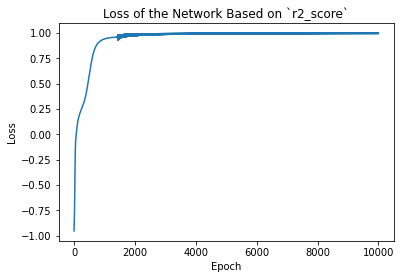

In [13]:
plt.plot(range(len(nn.history)), nn.history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Loss of the Network Based on `{nn.loss.__name__}`')